In [20]:
import os
import math
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Setup

In [2]:
driver_ids = []
with open('driver_ids.csv', 'r') as f:
    driver_ids_raw = f.readlines()[1:]
    for row in driver_ids_raw:
        parsed_row = row[:-1].split(',')
        parsed_row[1] = datetime.datetime.strptime(parsed_row[1], '%Y-%m-%d %H:%M:%S')
        driver_ids.append(parsed_row)
    
print("Number of drivers:", len(driver_ids))

driver_ids_map = {}
for driver_id, onboard_date in driver_ids:
    driver_ids_map[driver_id] = onboard_date

Number of drivers: 937


In [3]:
ride_ids = []
with open('ride_ids.csv', 'r') as f:
    ride_ids_raw = f.readlines()[1:]
    for row in ride_ids_raw:
        parsed_row = row[:-1].split(',')
        for i in range(2,5):
            parsed_row[i] = int(parsed_row[i]) 
        ride_ids.append(parsed_row)

print("Number of rides:", len(ride_ids))

ride_ids_map = {}
for driver_id, ride_id, ride_distance, ride_duration, ride_prime_time in ride_ids:
    ride_ids_map[ride_id] = [ride_distance, ride_duration, ride_prime_time]
    
driver_to_ride = {}
ride_to_driver = {}
for driver_id, ride_id, ride_distance, ride_duration, ride_prime_time in ride_ids:
    driver_to_ride.setdefault(driver_id, []).append(ride_id)
    ride_to_driver[driver_id] = ride_id

Number of rides: 193502


In [4]:
ride_timestamps = []
with open('ride_timestamps.csv', 'r') as f:
    ride_timestamps_raw = f.readlines()[1:]
    for row in ride_timestamps_raw:
        parsed_row = row[:-1].split(',')
        try:
            parsed_row[2] = datetime.datetime.strptime(parsed_row[2], '%Y-%m-%d %H:%M:%S')
        except:
            print(row)
            # TODO: 72f0fa0bd86800e9da5c4dced32c8735 has a missing timestamp with arrived at.
            # It is currently hard coded in using the picked up at time. This needs to be checked.
            parsed_row[2] = datetime.datetime.strptime("2016-04-20 12:02:20", '%Y-%m-%d %H:%M:%S')
        ride_timestamps.append(parsed_row)
    
print("Number of rides:", len(ride_timestamps))

ride_timestamps_map = {}
for ride_id, event, timestamp in ride_timestamps:
    #ride_timestamps_map[ride_id] = [event, timestamp]
    ride_timestamps_map.setdefault(ride_id, {})[event] = timestamp

72f0fa0bd86800e9da5c4dced32c8735,arrived_at,

Number of rides: 970405


In [5]:
data_structures = '''
List of Data Structures

driver_ids: 937 rows of ['driver_id', driver_onboard_date (datetime)]
driver_ids_map: 'driver_id' -> driver_onboard_date (datetime)

ride_ids: 193502 rows of ['driver_id', 'ride_id', ride_distance (int, m), ride_duration (int, s), ride_prime_time (int)]
ride_ids_map: 'ride_id' -> [ride_distance (int, m), ride_duration (int, s), ride_prime_time]
driver_to_ride: 'driver_id' -> list of ride_ids
ride_to_driver: 'ride_id' -> 'driver_id'

ride_timestamps: 970405 rows of ['ride_id', 'event', timestamp (datetime)]
ride_timestamps_map: 'ride_id' -> ('event' -> timestamp (datetime))

list of prime times: [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
list of events: ['requested_at', 'dropped_off_at', 'accepted_at', 'picked_up_at', 'arrived_at']
'''
print(data_structures)


List of Data Structures

driver_ids: 937 rows of ['driver_id', driver_onboard_date (datetime)]
driver_ids_map: 'driver_id' -> driver_onboard_date (datetime)

ride_ids: 193502 rows of ['driver_id', 'ride_id', ride_distance (int, m), ride_duration (int, s), ride_prime_time (int)]
ride_ids_map: 'ride_id' -> [ride_distance (int, m), ride_duration (int, s), ride_prime_time]
driver_to_ride: 'driver_id' -> list of ride_ids
ride_to_driver: 'ride_id' -> 'driver_id'

ride_timestamps: 970405 rows of ['ride_id', 'event', timestamp (datetime)]
ride_timestamps_map: 'ride_id' -> ('event' -> timestamp (datetime))

list of prime times: [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
list of events: ['requested_at', 'dropped_off_at', 'accepted_at', 'picked_up_at', 'arrived_at']



## Average Projected Driver Lifetime

Number of days


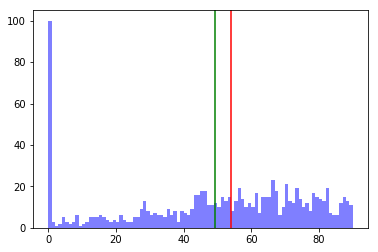

Lifetime Days Mean: 49.200640341515474 Lifetime Days Median: 54.0


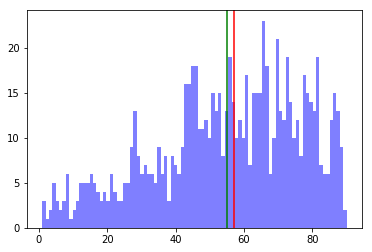

Lifetime Days Mean Clean: 55.07885304659498 Lifetime Days Median Clean: 57.0


In [6]:
print("Number of days")

driver_days = {}
for driver_id, onboard_date in driver_ids:
    max_time = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            max_time = max(max_time, (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days)
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_days[driver_id] = max_time

lifetime_days = list(driver_days.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 90
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)

lifetime_days_clean = [x for x in lifetime_days if x != 0]
lifetime_days_mean_clean = np.mean(np.asarray(lifetime_days_clean))
lifetime_days_median_clean = np.median(np.asarray(lifetime_days_clean))
n, bins, patches = plt.hist(lifetime_days_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean_clean, color='green')
plt.axvline(x=lifetime_days_median_clean, color='red')
plt.show()
print("Lifetime Days Mean Clean:", lifetime_days_mean_clean, "Lifetime Days Median Clean:", lifetime_days_median_clean)

Number of rides


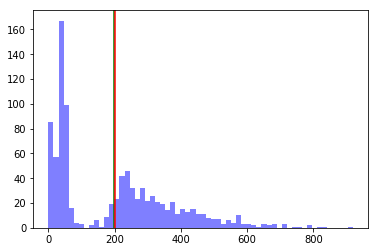

Lifetime Rides Mean: 198.3895410885806 Lifetime Rides Median: 200.0


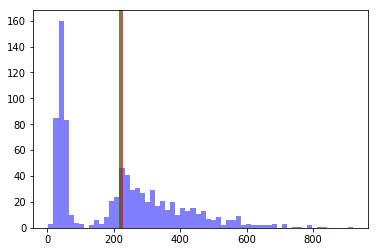

Lifetime Rides Clean Mean: 217.67096018735364 Lifetime Rides Clean Median: 223.0
83


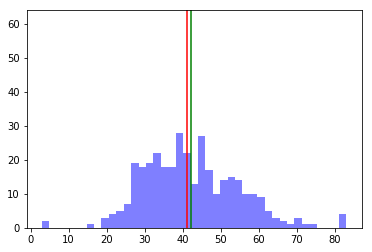

Lifetime Rides Short Mean: 42.176811594202896 Lifetime Rides Short Median: 41.0


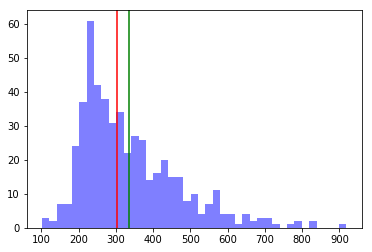

Lifetime Rides Long Mean: 336.6208251473477 Lifetime Rides Long Median: 302.0


In [7]:
print("Number of rides")
lifetime_rides = []
for driver_id, onboard_date in driver_ids:
    lifetime_rides.append(len(driver_to_ride.get(driver_id,[])))
lifetime_rides_mean = np.mean(np.asarray(lifetime_rides))
lifetime_rides_median = np.median(np.asarray(lifetime_rides))

num_bins = 60
n, bins, patches = plt.hist(lifetime_rides, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_mean, color='green')
plt.axvline(x=lifetime_rides_median, color='red')
plt.show()
print("Lifetime Rides Mean:", lifetime_rides_mean, "Lifetime Rides Median:", lifetime_rides_median)

lifetime_rides_clean = [x for x in lifetime_rides if x != 0]
lifetime_rides_clean_mean = np.mean(np.asarray(lifetime_rides_clean))
lifetime_rides_clean_median = np.median(np.asarray(lifetime_rides_clean))
n, bins, patches = plt.hist(lifetime_rides_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_clean_mean, color='green')
plt.axvline(x=lifetime_rides_clean_median, color='red')
plt.show()
print("Lifetime Rides Clean Mean:", lifetime_rides_clean_mean, "Lifetime Rides Clean Median:", lifetime_rides_clean_median)

num_bins = 41
lifetime_rides_short = [x for x in lifetime_rides_clean if x < 100]
print(max(lifetime_rides_short))
lifetime_rides_short_mean = np.mean(np.asarray(lifetime_rides_short))
lifetime_rides_short_median = np.median(np.asarray(lifetime_rides_short))
n, bins, patches = plt.hist(lifetime_rides_short, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_short_mean, color='green')
plt.axvline(x=lifetime_rides_short_median, color='red')
plt.ylim(top=64.05)
plt.show()
print("Lifetime Rides Short Mean:", lifetime_rides_short_mean, "Lifetime Rides Short Median:", lifetime_rides_short_median)

lifetime_rides_long = [x for x in lifetime_rides_clean if x >= 100]
lifetime_rides_long_mean = np.mean(np.asarray(lifetime_rides_long))
lifetime_rides_long_median = np.median(np.asarray(lifetime_rides_long))
n, bins, patches = plt.hist(lifetime_rides_long, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_long_mean, color='green')
plt.axvline(x=lifetime_rides_long_median, color='red')
plt.show()
print("Lifetime Rides Long Mean:", lifetime_rides_long_mean, "Lifetime Rides Long Median:", lifetime_rides_long_median)

Number of hours


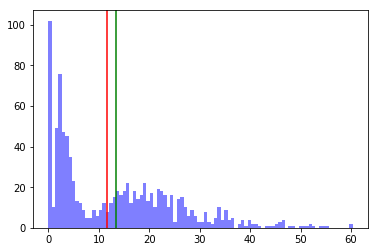

Lifetime Hours Mean: 13.428575536582473 Lifetime Hours Median: 11.725277777777778


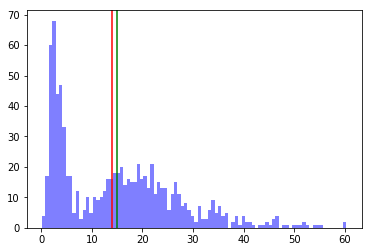

Lifetime Hours Mean Clean: 15.0329453736891 Lifetime Hours Median Clean: 14.051666666666668
6.9591666666666665


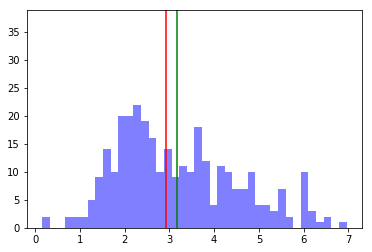

Lifetime Rides Short Mean: 3.1769976925807595 Lifetime Rides Short Median: 2.9125


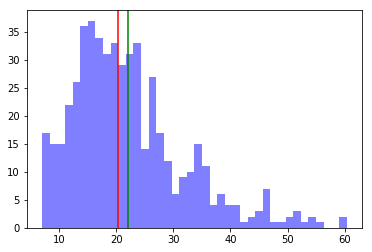

Lifetime Rides Long Mean: 22.11483778625954 Lifetime Rides Long Median: 20.24875


In [8]:
print("Number of hours")

driver_hours = {}
for driver_id, onboard_date in driver_ids:
    num_seconds = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            num_seconds += (ride_timestamps_map[ride_id]['arrived_at'] - ride_timestamps_map[ride_id]['accepted_at']).seconds
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_hours[driver_id] = num_seconds / 60 / 60

lifetime_hours = list(driver_hours.values())
lifetime_hours_mean = np.mean(np.asarray(lifetime_hours))
lifetime_hours_median = np.median(np.asarray(lifetime_hours))

num_bins = 90
n, bins, patches = plt.hist(lifetime_hours, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_mean, color='green')
plt.axvline(x=lifetime_hours_median, color='red')
plt.show()
print("Lifetime Hours Mean:", lifetime_hours_mean, "Lifetime Hours Median:", lifetime_hours_median)

lifetime_hours_clean = [x for x in lifetime_hours if x != 0]
lifetime_hours_mean_clean = np.mean(np.asarray(lifetime_hours_clean))
lifetime_hours_median_clean = np.median(np.asarray(lifetime_hours_clean))
n, bins, patches = plt.hist(lifetime_hours_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_mean_clean, color='green')
plt.axvline(x=lifetime_hours_median_clean, color='red')
plt.show()
print("Lifetime Hours Mean Clean:", lifetime_hours_mean_clean, "Lifetime Hours Median Clean:", lifetime_hours_median_clean)

num_bins = 40
lifetime_hours_short = [x for x in lifetime_hours_clean if x < 7]
print(max(lifetime_hours_short))
lifetime_hours_short_mean = np.mean(np.asarray(lifetime_hours_short))
lifetime_hours_short_median = np.median(np.asarray(lifetime_hours_short))
n, bins, patches = plt.hist(lifetime_hours_short, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_short_mean, color='green')
plt.axvline(x=lifetime_hours_short_median, color='red')
plt.ylim(top=38.85)
plt.show()
print("Lifetime Rides Short Mean:", lifetime_hours_short_mean, "Lifetime Rides Short Median:", lifetime_hours_short_median)

lifetime_hours_long = [x for x in lifetime_hours_clean if x >= 7]
lifetime_hours_long_mean = np.mean(np.asarray(lifetime_hours_long))
lifetime_hours_long_median = np.median(np.asarray(lifetime_hours_long))
n, bins, patches = plt.hist(lifetime_hours_long, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_long_mean, color='green')
plt.axvline(x=lifetime_hours_long_median, color='red')
plt.show()
print("Lifetime Rides Long Mean:", lifetime_hours_long_mean, "Lifetime Rides Long Median:", lifetime_hours_long_median)

Scatter plot of days vs. rides


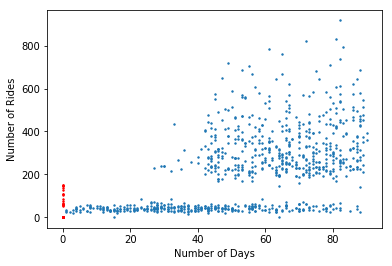

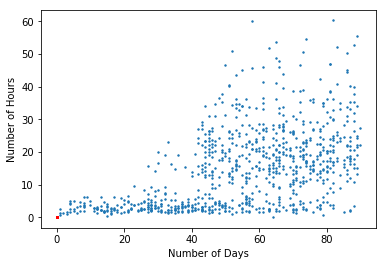

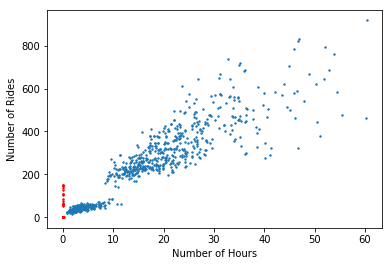

In [9]:
print("Scatter plot of days vs. rides")
x_days_clean = []
y_rides_clean = []
x_days_full = []
y_rides_full = []
for driver_id, days in driver_days.items():
    if driver_hours[driver_id] != 0:
        x_days_clean.append(days)
        y_rides_clean.append(len(driver_to_ride.get(driver_id,[])))
    else:
        x_days_full.append(days)
        y_rides_full.append(len(driver_to_ride.get(driver_id,[])))
        
plt.xlabel('Number of Days')
plt.ylabel('Number of Rides')
plt.scatter(x_days_clean,y_rides_clean,s=2)
plt.scatter(x_days_full,y_rides_full,s=2,color='red')
plt.show()

x_days_clean = []
y_hours_clean = []
x_days_full = []
y_hours_full = []
for driver_id, days in driver_days.items():
    if driver_hours[driver_id] != 0:
        x_days_clean.append(days)
        y_hours_clean.append(driver_hours[driver_id])
    else:
        x_days_full.append(days)
        y_hours_full.append(driver_hours[driver_id])
        
plt.xlabel('Number of Days')
plt.ylabel('Number of Hours')
plt.scatter(x_days_clean,y_hours_clean,s=2)
plt.scatter(x_days_full,y_hours_full,s=2,color='red')
plt.show()

x_hours_clean = []
y_rides_clean = []
x_hours_full = []
y_rides_full = []
for driver_id, hours in driver_hours.items():
    if driver_hours[driver_id] != 0:
        x_hours_clean.append(hours)
        y_rides_clean.append(len(driver_to_ride.get(driver_id,[])))
    else:
        x_hours_full.append(hours)
        y_rides_full.append(len(driver_to_ride.get(driver_id,[])))

plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.scatter(x_hours_clean,y_rides_clean,s=2)
plt.scatter(x_hours_full,y_rides_full,s=2,color='red')
plt.show()

In [10]:
driver_hours = {}
for driver_id, onboard_date in driver_ids:
    num_seconds = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            num_seconds += (ride_timestamps_map[ride_id]['arrived_at'] - ride_timestamps_map[ride_id]['accepted_at']).seconds
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_hours[driver_id] = num_seconds / 60 / 60

Heatmap plot of days vs. rides


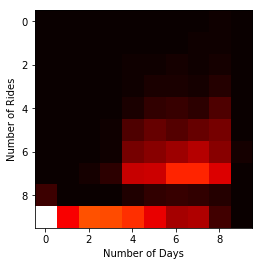

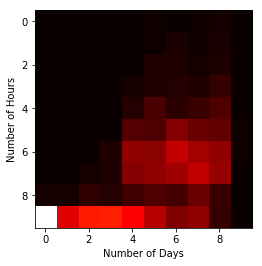

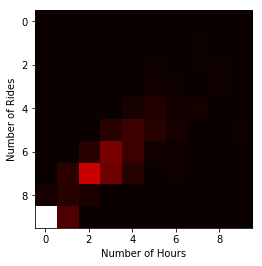

In [11]:
print("Heatmap plot of days vs. rides")
days_rides_heatmap = np.zeros((10,10))
for driver_id, days in driver_days.items():
    x_days = days
    y_rides = len(driver_to_ride.get(driver_id,[]))
    days_rides_heatmap[max(0,9-int(y_rides/100)),min(9,int(x_days/10))] += 1

plt.xlabel('Number of Days')
plt.ylabel('Number of Rides')
plt.imshow(days_rides_heatmap, cmap='hot')
plt.show()

days_hours_heatmap = np.zeros((10,10))
for driver_id, days in driver_days.items():
    x_days = days
    y_hours = driver_hours[driver_id]
    days_hours_heatmap[max(0,9-int(y_hours/6)),min(9,int(x_days/10))] += 1
    
plt.xlabel('Number of Days')
plt.ylabel('Number of Hours')
plt.imshow(days_hours_heatmap, cmap='hot')
plt.show()

hours_rides_heatmap = np.zeros((10,10))
for driver_id, hours in driver_hours.items():
    x_hours = hours
    y_rides = len(driver_to_ride.get(driver_id,[]))
    hours_rides_heatmap[max(0,9-int(y_rides/100)),min(9,int(x_hours/6))] += 1
    
plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.imshow(hours_rides_heatmap, cmap='hot')
plt.show()

## Categories of Drivers

Day of week


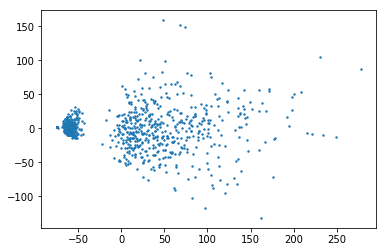

Component 1 (count): [0.28132626 0.32709573 0.36623304 0.3997014  0.44944649 0.45488873
 0.33324191]
Component 2 (weekend): [-0.21418311 -0.33965469 -0.31149743 -0.28765337 -0.10146957  0.54830229
  0.58996076]
Component 3 (??): [ 0.51230235  0.28849935  0.04305716 -0.12423998 -0.52027016 -0.31455726
  0.51710505]
Explained Variance: [4826.64440583  764.43579472  246.77917925  162.57920483  137.18888002
  115.85724781  108.42134342]


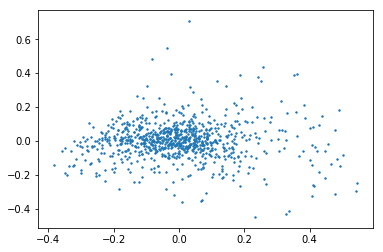

Component 1 (weekend): [-0.16262872 -0.3044233  -0.36979355 -0.32882914  0.04139462  0.59594908
  0.52833101]
Component 2 (friday night?): [-0.21889466 -0.19760977 -0.09491803  0.05693102  0.75502086  0.22760396
 -0.52813338]
Component 3 (??): [ 0.04547594  0.07528676 -0.2634863  -0.18097607  0.52157315 -0.64596094
  0.44808746]
Explained Variance: [2.48248895e-02 1.30048971e-02 8.63469449e-03 7.94540903e-03
 6.83754691e-03 5.85065974e-03 1.29577964e-31]


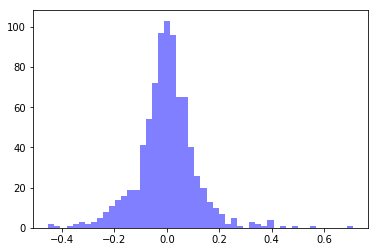

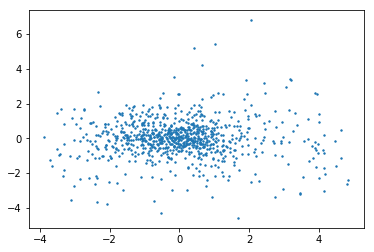

Component 1 (weekend): [-0.16262872 -0.3044233  -0.36979355 -0.32882914  0.04139462  0.59594908
  0.52833101]
Component 2 (friday night?): [-0.21889466 -0.19760977 -0.09491803  0.05693102  0.75502086  0.22760396
 -0.52813338]
Component 3 (??): [ 0.04547594  0.07528676 -0.2634863  -0.18097607  0.52157315 -0.64596094
  0.44808746]
Explained Variance: [2.48248895e-02 1.30048971e-02 8.63469449e-03 7.94540903e-03
 6.83754691e-03 5.85065974e-03 1.29577964e-31]


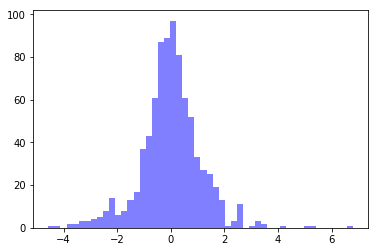

In [12]:
print("Day of week")

# Full
driver_weekday = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_weekday[driver_id] = weekday_counts
    
X = np.asarray([days for driver_id, days in driver_weekday.items()])
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=2)
plt.show()

print("Component 1 (count):", pca.components_[0])
print("Component 2 (weekend):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Clean
driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        total = sum(weekday_counts)
        for i in range(7):
            weekday_counts[i] = weekday_counts[i] / total
        driver_weekday_clean[driver_id] = weekday_counts

X_clean = np.asarray([days for driver_id, days in driver_weekday_clean.items()])
pca = PCA(n_components=7)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (weekend):", pca.components_[0])
print("Component 2 (friday night?):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

num_bins = 50
n, bins, patches = plt.hist(X_pca_clean[:,1], num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Normed
driver_weekday_norm = driver_weekday_clean
X_norm = np.asarray([days for driver_id, days in driver_weekday_norm.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=7))])
X_pca_norm = pipeline.fit_transform(X_norm)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (weekend):", pca.components_[0])
print("Component 2 (friday night?):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

num_bins = 50
n, bins, patches = plt.hist(X_pca_norm[:,1], num_bins, facecolor='blue', alpha=0.5)
plt.show()

Percentage of weekend rides
Only week days percentage: 5.734767025089606
Only weekend percentage: 0.23894862604540024


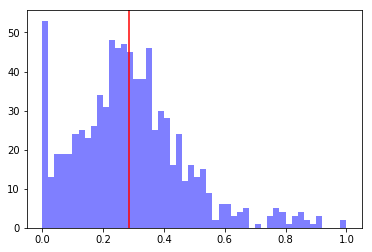

In [30]:
print("Percentage of weekend rides")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        total = sum(weekday_counts)
        driver_weekday_clean[driver_id] = (weekday_counts[5]+weekday_counts[6])/total
        
print("Only week days percentage:",len([x for x in driver_weekday_clean.values() if x < .001])/len(driver_weekday_clean.values())*100)
print("Only weekend percentage:",len([x for x in driver_weekday_clean.values() if x > .99])/len(driver_weekday_clean.values())*100)


weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=2/7, color='red')
plt.show()

Entropy of week


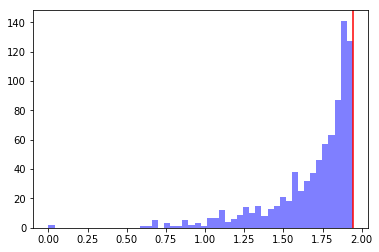

Entropy of week vs. weekend
Just weekend or just weekdays percentage: 5.973715651135006


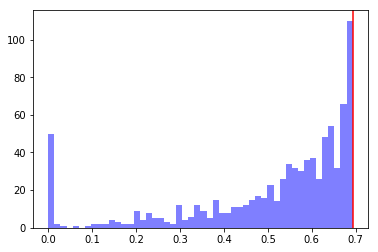

In [33]:
print("Entropy of week")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        entropy = 0
        total = sum(weekday_counts)
        for i in range(7):
            if weekday_counts[i] > 0:
                entropy -= weekday_counts[i]/total * math.log(weekday_counts[i]/total)
        driver_weekday_clean[driver_id] = entropy
                
weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=math.log(7), color='red')
plt.show()

print("Entropy of week vs. weekend")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        entropy = 0
        total = sum(weekday_counts)
        weekday = np.sum(np.asarray(weekday_counts)[:5])
        weekend = np.sum(np.asarray(weekday_counts)[5:])
        if weekday > 0:
            entropy -= weekday/total*math.log(weekday/total)
        if weekend > 0:
            entropy -= weekend/total*math.log(weekend/total)
        driver_weekday_clean[driver_id] = entropy 
        
print("Just weekend or just weekdays percentage:",len([x for x in driver_weekday_clean.values() if x < .001])/len(driver_weekday_clean.values())*100)
        
weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=math.log(2), color='red')
plt.show()

Hour of day


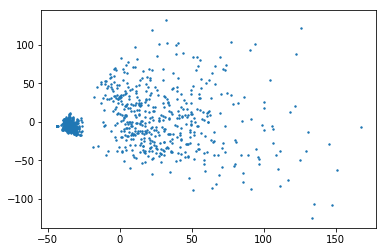

Component 1 (count): [0.16886712 0.12407257 0.06558523 0.02778441 0.01929102 0.02520159
 0.05767338 0.13572776 0.17425706 0.17917289 0.14792774 0.14316655
 0.13250953 0.13545515 0.14663947 0.17698335 0.21474736 0.28069323
 0.355469   0.36126898 0.33157421 0.31765501 0.29961319 0.22866422]
Component 2 (day): [-0.20834519 -0.17243879 -0.0980631  -0.05124255 -0.02143862  0.0235173
  0.11509298  0.24244031  0.30572512  0.35344589  0.31147649  0.28161993
  0.25536862  0.21839056  0.17598449  0.14477269  0.10981327  0.06628768
 -0.01412321 -0.10841353 -0.18862009 -0.26264331 -0.29000698 -0.2548589 ]
Component 3 (afternoon): [ 0.20785648  0.19827742  0.13899187  0.09011566  0.07939437  0.10084261
  0.18937949  0.29526419  0.31608927  0.3065955   0.18027967  0.09110444
 -0.04239152 -0.14821941 -0.21369494 -0.28796631 -0.31666229 -0.29745619
 -0.23651012 -0.16152714 -0.03227512  0.0952837   0.19027844  0.21527652]
Explained Variance: [1.73630968e+03 9.01535825e+02 3.52662783e+02 2.16801402e+02


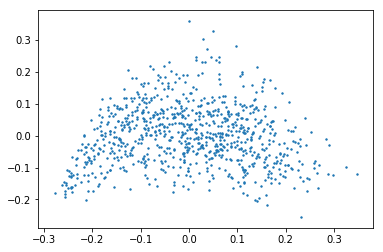

Component 1 (day): [ 0.19457996  0.14170614  0.08058725  0.03834601  0.01374288 -0.02243225
 -0.07713766 -0.16881445 -0.23238391 -0.28575661 -0.25745461 -0.24195908
 -0.21883184 -0.18697058 -0.16591912 -0.13007666 -0.07837001 -0.01294938
  0.07575291  0.18963951  0.29421915  0.40091668  0.37424981  0.27531583]
Component 2 (afternoon): [-0.19367298 -0.16466663 -0.11191    -0.07369242 -0.05364966 -0.05447357
 -0.09960515 -0.14741137 -0.18999493 -0.19908492 -0.16405456 -0.10693946
 -0.00521982  0.08325451  0.13746997  0.21701529  0.32678786  0.39047991
  0.4474351   0.32787889  0.15552111 -0.08875007 -0.20548982 -0.22722727]
Component 3 (??): [ 0.16745253  0.13715931  0.08242208  0.05568797  0.01379954 -0.05423443
 -0.15604283 -0.28379184 -0.35506403 -0.30736802 -0.09693424  0.10426514
  0.20611886  0.29951388  0.37455647  0.30314915  0.11743639 -0.07110389
 -0.26176655 -0.24435493 -0.20036806 -0.0800673   0.07346027  0.17607454]
Explained Variance: [1.63378898e-02 9.05126438e-03 5.356611

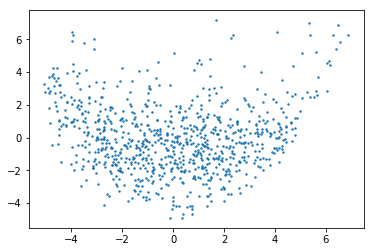

Component 1 (day): [ 0.19457996  0.14170614  0.08058725  0.03834601  0.01374288 -0.02243225
 -0.07713766 -0.16881445 -0.23238391 -0.28575661 -0.25745461 -0.24195908
 -0.21883184 -0.18697058 -0.16591912 -0.13007666 -0.07837001 -0.01294938
  0.07575291  0.18963951  0.29421915  0.40091668  0.37424981  0.27531583]
Component 2 (afternoon): [-0.19367298 -0.16466663 -0.11191    -0.07369242 -0.05364966 -0.05447357
 -0.09960515 -0.14741137 -0.18999493 -0.19908492 -0.16405456 -0.10693946
 -0.00521982  0.08325451  0.13746997  0.21701529  0.32678786  0.39047991
  0.4474351   0.32787889  0.15552111 -0.08875007 -0.20548982 -0.22722727]
Component 3 (??): [ 0.16745253  0.13715931  0.08242208  0.05568797  0.01379954 -0.05423443
 -0.15604283 -0.28379184 -0.35506403 -0.30736802 -0.09693424  0.10426514
  0.20611886  0.29951388  0.37455647  0.30314915  0.11743639 -0.07110389
 -0.26176655 -0.24435493 -0.20036806 -0.0800673   0.07346027  0.17607454]
Explained Variance: [1.63378898e-02 9.05126438e-03 5.356611

In [14]:
print("Hour of day")

# Full
driver_weekday = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_weekday[driver_id] = hour_counts

X = np.asarray([days for driver_id, days in driver_weekday.items()])
pca = PCA(n_components=24)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=2)
plt.show()

print("Component 1 (count):", pca.components_[0])
print("Component 2 (day):", pca.components_[1])
print("Component 3 (afternoon):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Clean
driver_weekday_clean = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(hour_counts) > 0:
        total = sum(hour_counts)
        for i in range(24):
            hour_counts[i] = hour_counts[i]/total
        driver_weekday_clean[driver_id] = hour_counts

X_clean = np.asarray([days for driver_id, days in driver_weekday_clean.items()])
pca = PCA(n_components=24)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (day):", pca.components_[0])
print("Component 2 (afternoon):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Normed
X_norm = np.asarray([days for driver_id, days in driver_weekday_norm.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=24))])
X_pca_norm = pipeline.fit_transform(X_clean)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (day):", pca.components_[0])
print("Component 2 (afternoon):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

Percentage of out of work day rides
Just workday percentage: 3.464755077658303


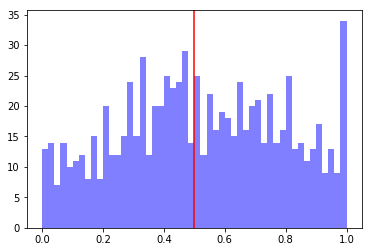

In [15]:
print("Percentage of out of work day rides")
        
driver_weekday_clean = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(hour_counts) > 0:
        total = sum(hour_counts)
        driver_weekday_clean[driver_id] = np.sum(np.asarray(hour_counts)[6:18]) / total
        
print("Just workday percentage:",len([x for x in driver_weekday_clean.values() if x > .99])/len(driver_weekday_clean.values())*100)

weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=12/24, color='red')
plt.show()

## Cost Analysis Setup

In [16]:
def ride_cost(ride_distance, ride_duration, ride_prime_time):
    cost = 2.0+1.15*(ride_distance/1609.34)+0.22*(ride_duration/60.0/60.0)+1.75
    cost = min(max(5.0, cost), 500)
    return cost*(ride_prime_time/100.0)

## Lifetime Value Setup

In [17]:
#total money made, total days active, total days employed, total hours active
#of the form {driver_id -> [total money, total days active, total days employed, total hours active]}
driver_lifetime_metadata = {} 
#data for every day of the form {driver_id -> {day number -> hours, money, or active}}
driver_lifetime_hours = {}
driver_lifetime_money = {}
driver_lifetime_active = {}

for driver_id, onboard_date in driver_ids:
    total_money = 0.0
    total_days_active = set()
    total_days_employed = 0
    total_hours_active = 0
                
    hours_temp = {}
    money_temp = {}
    active_temp = {}
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            ride_money = ride_cost(ride_ids_map[ride_id][0],ride_ids_map[ride_id][1],ride_ids_map[ride_id][2])
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days

            total_money += ride_money
            total_days_active.add(ride_day)
            total_days_employed = max(total_days_employed, ride_day)
            total_hours_active += ride_duration

            if(ride_day in hours_temp):
                hours_temp[ride_day] += ride_duration
                money_temp[ride_day] += ride_money
            else:
                hours_temp[ride_day] = ride_duration
                money_temp[ride_day] = ride_money
            active_temp[ride_day] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    hours_temp = {k: v /60/60 for k, v in hours_temp.iteritems()}
    driver_lifetime_hours[driver_id] = hours_temp
    driver_lifetime_money[driver_id] = money_temp
    driver_lifetime_active[driver_id] = active_temp
    driver_lifetime_metadata[driver_id] = [total_money,len(total_days_active),total_days_employed+1,total_hours_active / 60 / 60]
#print(driver_lifetime_active)

AttributeError: 'dict' object has no attribute 'iteritems'

In [ ]:
print("Histogram of (#active/#employed)*100 days")
active_over_employed = []
for driver_id, onboard_date in driver_ids:
    if(driver_lifetime_metadata[driver_id][1] > 0):
        active_over_employed.append(100*(driver_lifetime_metadata[driver_id][1]+0.0)/driver_lifetime_metadata[driver_id][2])
active_over_employed_mean = np.mean(np.asarray(active_over_employed))
active_over_employed_median = np.median(np.asarray(active_over_employed))
num_bins = 90
n, bins, patches = plt.hist(active_over_employed, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=active_over_employed_mean, color='green')
plt.axvline(x=active_over_employed_median, color='red')
plt.show()
print("Active/Employed Days Mean:", active_over_employed_mean, "Active/Employed Days Median:", active_over_employed_median)